# BIBLIOTECAS

In [78]:
# IMPORTS
import numpy as np
import pandas as pd
import scipy.integrate as integrate

# METPY IMPORTS
import metpy
from metpy.units import units

# MATPLOTLIB IMPORTS
import matplotlib.pyplot as plt

# **Funções**

**Integral e Derivada**

In [143]:
def dfdx(y, x):
	'''
	Calcula a derivada da função F com relaçao a X, utilizando
	o método de diferenca centradas em X.
	O primeiro e ultimo elementos do array resultante serão NaN.

		f = array de N elementos com os resultados da função em cada X.
		x = array de N elementos com o respectivo valor X.
	'''

	# # Calculando a derivada em Cada X.
	# for i in range(1, N - 1):
	# 	df = f[i + 1] - f[i - 1]
	# 	dx = x[i + 1] - f[i - 1]
		
	# 	results[i] = df/dx

	# return results

	dy = np.diff(y)
	dx = np.diff(x)
	
	return np.insert(dy/dx, -1, np.nan)

def integral(y, x):
	'''
	Calcula a derivada da função F com relaçao a X, utilizando
	o método trapezoidal.

		f = array de N elementos com os resultados da função em cada X.
		x = array de N elementos com o respectivo valor X.
	'''

	# Organizando o array na ordem crscente, de acordo com X.
	ind = np.argsort(x)
	y_sorted = y[ind]
	x_sorted = x[ind]

	# Calculando a area de cada intervalo (integral)
	dx = x_sorted[1:] - x_sorted[:-1]
	area = dx * (y_sorted[1:] + y_sorted[:-1]) / 2

	return np.nansum(area)

**Densidade do Gás Absorvedor $(\rho)$**

	Ref: A Short Course in Cloud Physics (1996) - Chapter 2

	Neste caso, a densidade do vapor d'água em cada nível da atmosfera
	a partir de dados de sondagem atmosférica

	Sabendo temperatura do ponto de orvalho, podemos calcular
	a pressao de vapor na equação abaixo substituindo T por Td.
	
![h2o-pres](Imagens\vapor-pressure.png)

	Sabendo a pressao do ar umido (seco + vapor), e razao de mistura, 
	a densidade do vapor pode ser derivada das equações abaixo.
	
![h2o-mixr](Imagens\mixing-ratio.png)


In [79]:
def saturation_vapor_pressure(T):
	return 6.112 * np.exp((17.67 * T) / (243.5 + T))

def density_water_vapour(p, T, Td, w):
    # condicoces inciais
	T = T # temperatura em Celsius
	Td = Td # temperatura do ponto de orvalho
	w = w.to('dimensionless') # razao de mistura sem dimensao (kg/kg)

	# Calculando a pressão de vapor
	# --------------------------------------------------------
	e = saturation_vapor_pressure(Td.magnitude) * units('hPa')

	# Calculando a densidade do vapor d´agua
	# --------------------------------------------------------
	# constante do ar seco
	R = 287 * units('J * kg^-1 * degK^-1')

	# densidade do ar seco
	Qd = (p - e)/ (R * T)

	# densidade do vapor d´agua
	Qv = w * Qd

	return Qv.to('g * cm^-3')

**PATH LENGTH (U) - NÃO LEMBRO A TRADUÇÃO (CAMINHO ÓPTICO?)**

	definida como uma integral da densidade do gás
	absorvedor em função da altitude, desde o topo da atmosfera
	até o nível de interesse. (Equação 3.2.16 do livro do LIOU)

	Porém, para o infravermelho, consideramos da superfície para cima.
	Assim, u(z = 0) = 0
![Path-length](Imagens\path-length.png)

In [89]:
def PathLength(rho, z):
	'''
	Calcula o Path Length a partir da integral da densidade do gás absorvedor
	desde a superfície até o nível de referência.
	Utiliza o método trapezoidal.

		| rho = array de densidade do gas absorvedor[g/cm³]
		| z = array da altitude [cm]
		| func_kwargs = dicionario contendo os argumentos da funcao integrate.simpson (opcional)
	'''
	# armazena os resultados da integração até cada nivel
	results = np.zeros(rho.shape, dtype= np.float64) 

	# loop para cada nivel
	for i in range(rho.shape[0]):
		
		results[i] = integral(rho[:i + 1], z[:i+1])

	return results

**Lei de Planck e Stefan-Boltzmann**

In [81]:
def Planck(v, T):
	'''
	Calcula a Lei de Planck para um dado numero de onda e Temperatura.
	Densidade de Fluxo de Energia

		v = comprimento de onda [m]
		T = temperatura [k]
	'''
	# Constante de PLanck (J * s)
	h = 6.626 * 1e-34

	# Constante de Boltzmann (J / K)
	K = 1.3806 * 1e-23 

	# light speed (3 x 10^8 m/s)
	c = 3 * 1e8

	# Lei de Planck
	numerador = 2 * h * c ** 2
	denominador = v ** 5 * (np.exp(h * c / (K * v * T)) - 1)
	B = numerador / denominador

	return B

def StefanBoltzmann(T):
	'''
	Calcula a Lei de Stefan-Boltzmann para um dada Temperatura.
	Unidade resultante: [J * m^-2 * s^-1]

		T = temperatura [k]
	'''
	constante = 5.67 * 1e-8 # J * m^-2 * s^-1 * T*^-4

	return constante * T ** 4


# **Fluxo de Emissividade Broadband**


**H2O - BANDA ROTACIONAL (0 a 1000 cm^-1)**

	Para considerar os efeitos da temperatura e pressão, Rodgers e Walshaw (1966) propuseram uma abordagem empírica, tal que:

![intensity-rotational](Imagens\line-strength-rotational.png)

	Onde T0 = 260K, e os valores a, b, a' e b' são constantes empíricas derivadas
	de mecânica quântica (?). Rodgers & Walshaw (1966) disponibilizam o valor destas constantes
	para a banda rotacional do H20.
	Segue da tabela abaixo, onde k equivale a S (mean line strength)

![rotational-constants](Imagens\rotational-constants.png)

	Fonte: The computation of infrared cooling rate in planetary atmospheres (Rodgers & Walshaw, 1966)

	Ajustando o Path Length para temperatura e pressão, considerando a banda
	rotacional, utilizamos o seguinte valor corrigido.

![path-length-rotationl](Imagens\path-length-corrigido-rotational.png)
	

In [146]:
def reduced_path_length_H2O_r(p, T, u):
	'''
	Calcula o path length reduzido de acordo com a equação acima (22)

		| p = array de pressao em hPa
		| T = array de temperatura em K
		| u = array de Path length em g / cm²

	Existem duas formas de calcular qual seria a pressão do ar em T = T0 (2)
	1. Processo Isobárica, onde o termo p / p0 = T / T0
	2. Processo Adiabática, onde o termo p / po = (T / T0) ** (Cp / R)

	Esta função considera um processo adiabático.
	'''
	# Iniciliza variáveis
	A_ = 0
	B_ = 0

	# a' e b' para cada interalo de numero de onda
	a_ = np.array(
		[-2.68, 2.03, 9.08, 15.1, 16.2, 18.6, 23.1, 26.2, 28.5],
		) * 1e-3 # (deg^-1)
	b_ = np.array(
		[1.57, -10.3, -38.1, -54.1, -38.1, -62.6, -74.7, -74.1, -86.8],
		) * 1e-6 # (deg^-2)
	
	# intervalo de numero de onda
	intervalos = [
		# (0, 40),
	    (40, 160),
		(160, 280),
		(280, 380),
		(380, 500),
		(500, 600),
		(600, 720),
		(720, 800),
		(800, 900),
		(900, 1000)] # cm^-1

	# loop para cada intervalo de numero de onda
	for i in range(len(intervalos)):
		dvi = intervalos[i][1] - intervalos[i][0]
		
		# Calcula A'
		A_ += a_[i] * dvi

		# Calcula B'
		B_ += b_[i] * dvi

	# Divide por dv
	dv = 960 # cm^-1
	A_ = A_ / dv # final A'
	B_ = B_ / dv # final B'

	# INTEGRAL
	# ----------------------------------------------
	# Estima a pressao e temperatura na superficie por interpolacao
	T0 = 260

	# Funcao a ser integrada
	Cp = 1005 # J * Kg^-1 * K^-1
	R = 287 # J * Kg^-1 * K^-1
	y = T / T0 ** (Cp / R) * np.exp(A_ * (T - T0) + B_ * (T - T0) ** 2) 

	# Integracao
	results = np.zeros(u.shape, dtype = np.float64)
	for i in range(u.shape[0]):

		results[i] = integral(y[:i+ 1], u[:i + 1])

	return results


def transmitance_rotational_H2O(T, u):
	'''
	Calcula a transmitância devido a banda rotacional do H2O.
	Retorna uma lista, com a transmitância em cada intervalo segundo Rodgers & Walshaw (1966)

	u = Path length Corrigido para banda rotacional (equação 22 do Liou)
	T = Temperatura
	'''
	# DEFININDO AS VARIAVEIS
	# -------------------------------------------------------------------
	# constantes
	a = np.array(
		[-2.93, 1.43, 9.59, 14.3, 15.2, 19.0, 21.7, 24.1, 12.9],
		) * 1e-3 # (deg^-1)
	
	b = np.array(
		[2.01, -13, -41.8, -23.7, -30.1, -44.6, -53.2, -40.3, 165],
		) * 1e-6 # (deg^-2)

	# k / delta (g^-1 cm²)
	Rw1 = np.array([7210.3, 6024.8, 1614.1, 139.03, 21.64, 2.919, 0.3856, 0.0715, 0.0209])

	# pi * alpha_0 / delta (adimensional)
	Rw2 = np.array([0.182, 0.094, 0.081, 0.080, 0.068, 0.060, 0.059, 0.067, 0.051])

	# intervalo de numero de onda
	intervalos = [
		# (0, 40),
	    (40, 160),
		(160, 280),
		(280, 380),
		(380, 500),
		(500, 600),
		(600, 720),
		(720, 800),
		(800, 900),
		(900, 1000)] # cm^-1
	
	# Calculos
	# ------------------------------------------------------------
	T0 = 260 # K
	S_S0 = np.exp(a * (T - T0) + b * (T - T0) ** 2) # S / S0

	# Transmitancia Difusa
	termo_raiz = 1 + 1.66 * S_S0 * Rw2 / Rw1 * u
	transmitance = 1.66 * S_S0 * Rw1 * u / np.power(termo_raiz, 0.5)
	transmitance = np.exp(-transmitance)
	
	return dict(zip(intervalos, transmitance))

**H20 - Banda 10 µm [8 - 12 µm]**

	Artigo: Infrared continuum absorption by atmospheric water vapor
	in the 8-12-m window. (Roberts et al., 1976)
	
	Nesta banda, a fórmula empírica para o coeficiente de absorção
	molar do H20 dada por Roberts et al. (1976) é utilizada.

	
![absorption-rodgers](Imagens\rodgers-absorption.png)

	Onde os parâmetros da regressão, obtidos por dados experimentais,
	são:

![fit-rodgers](Imagens\fit-rodgers.png)

	Nesta banda, a absorção depende fortemente da temperatura, assim,
	uma correção considerando os efeitos de T foi desenvolvida.
	Liou (1981) considera T0 = 1800 [Bignell].


![absorption-rodgers-2](Imagens\absorption-rodgers-2.png)

	Segundo Liou (1981), o seguinte Path Length Corrigido foi desenvolvido para esta banda.


T0 = 296 K

P0 = Pressão de Vapor em T = 296 K

![path-length-10µm](Imagens\path-length-corrigido-10.png)

In [103]:
def path_length_10µm(T, u):
	'''
	Calcula o Path Length corrigido para esta banda de absorção [8 - 12 µm]

		T = Temperatura [K] - Array
		u = Path Length do H20  [g / cm²] - Array

	Existem duas formas de calcular qual seria a pressão do gás absorvedor em T = T0 (2)
	1. Processo Isobárica, onde o termo p / p0 = T / T0
	2. Processo Adiabática, onde o termo p / po = (T / T0) ** (Cp / R)

	Esta função considera um processo adiabático.
	'''
		
	# Definindo variaveis
	# --------------------------------------------
	T0 = 296 # K
	R = 461.5 # R do vapor d´agua [J * Kg^-1 * K^-1]
	Cv = 1410 # Cv do vapor d'água  [J * Kg^-1 * K^-1]
	Cp = Cv + R # Cp do vapor d'agua [J * Kg^-1 * K^-1]
	
	# Integrando da superfície até o topo
	# ---------------------------------------------

	# funcao a ser integrada
	y = ( (T / T0) ** (Cp / R) ) * np.exp(- 1800 / (T0 * T) * (T - T0))

	# Calculando a integral da sup até cada nivel (Metodo trapezoidal)
	new_u = np.zeros(u.shape, dtype = np.float64)
	for i in range(new_u.shape[0]):

		# Nivel i
		new_u[i] = integral(y[:i + 1], u[:i + 1])

	return new_u
        

def absorption_10µm(T, u):
	'''
	Calcula o coeficiente de absorção (absorção = emissividade = 1 - transmissao)
	do H20 para banda de 10 µm

		T = Temperatura [K] - Escalar
		u = Path Length do H20 - Corrigido para P e T nesta banda [g / cm²] - Escalar

	'''

	# Constantes
	a = 1.25 * 1e-22 # mol^-1 * cm² * atm^-1
	b = 2.34 * 1e-19 # mol^-1 * cm² * atm^-1
	beta = 8.3 * 1e-3 # cm

	# Intervalos de comprimento de onda em cm
	intervalos = np.linspace(8, 12, 41) * 1e-4 # em cm
	vmean = (intervalos[1:] + intervalos[:-1]) / 2
	dlambda = intervalos[1:] - intervalos[:-1] 

	# calculos realizado com o valor médio
	C = a + b * np.exp(beta / vmean)

	# correcao de temperatura
	C = C * np.exp(1800 (1 / T - 1 / 296))

	# Calculo da absortividade (absortividde = emissividade)
	c = np.nan # Concentração molar
	absortividade = C * u * c

	return vmean, dlambda, absortividade

<>:62: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:62: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
C:\Users\Lucas\AppData\Local\Temp\ipykernel_388\4155289246.py:62: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  C = C * np.exp(1800 (1 / T - 1 / 296))


**Emissividade Broadband Total**


	Calculado para cada gás absorverdor (dependencia de u),
	através da integração ao longo do espectro.
	Neste caso -> Espectro infravermelho
	
	Referencia: Liou (1981)
![broadband-emissivity](Imagens\broadband-emissivity.png)

	A transmitância difusa para uma frequência e gás absorvedor é obtida pela
	equação abaixo. Onde:

$\delta$ = Mean Line Spacing (cm^-1)

s = Mean Line Intensity / Strength (g^-1 * cm^3)

$\alpha$ = Mean Line Width (variável)

![diffuse-transmittance](Imagens\transmission-function.png)

In [104]:
def broadband_emissivity(u, T, p):
	'''
	Calcula a emissividade broadband para um dado intervalo espectral no IR
	Neste caso entre 0 - 1000 cm^-1, considerando APENAS o vapor d'agua.

		T = Temperatura [K] - array
		Td = Temperatura do Ponto de Orvalho [k] - array
		u = Path Length do H20 - Corrigido para Banda Rotacional [g / cm²] - array
		p = Pressão Atmosférica [hPa] - array
	'''
	
	# Emissividade = Somatoria (originada de uma integral)
	Emissivity = np.zeros(T.shape, dtype = np.float64)
	
	# Lei de Stefan-Boltzmann
	SteBoltz = StefanBoltzmann(T) # J * m^-2 * s^-1

	# Path Length corrigido - H2O Rotational
	u_rot = reduced_path_length_H2O_r(p, T, u)

	# Path length corrigid - Banda 10 µm
	u_10 = path_length_10μm(T, u)
	# print(u_10)

	# LOOP PRINCIPAL, PARA CADA NIVEL DA SONDAGEM
	for i in range(Emissivity.shape[0]):

		# BROADBAND H20 ROTACIONAL [0 A 1000 CM^-1]
		# --------------------------------------------------------------------------

		# transmitancia para cada intervalo do rotacional
		tau_r = transmitance_rotational_H2O(T[i], u_rot[i]) # key = cm^-1 | v = Transmit
		
		# Integral para cada intervalo de numero de onda 
		for key in tau_r.keys():

			# transforma em comprimento de onda (cm) e converte para metros
			v1 = 1 / key[0] * 1e-2
			v2 = 1 / key[1] * 1e-2
			mean_v = (v2 + v1) / 2
			dlambda = np.abs(v2 - v1)

			# Calcula emissividade deste intervalo e contabiliza
			planck = Planck(mean_v, T[i])
			Emissivity[i] += np.pi * planck * (1 - tau_r[key]) * dlambda


		# ABSORÇÃO DO H20 NA BANDA 10 micrometros [8, 12])
		# --------------------------------------------------------------------------
		# E_10 = absorption_10μm(T[i], u[i])
		
		# RESULTADO FINAL
		# -----------------------------------------------------------------
		Emissivity[i] = Emissivity[i] / SteBoltz[i]

	return Emissivity

# **Cooling Rate (Sem Nuvens)**

![clear-column](Imagens/clear-column-rate.png)

	T1 = Temperatura no topo da atmosfera (topo da sondagem)
	u1 = Total Path Length para o gás específico
	q = razão de mistura
	Cv = Calor específico a volume constante

In [105]:
def cooling_rate_no_clouds(T, u, p, w):
    '''
    Calcula a taxa de resfriamento, considerando uma atmosfera sem nuvens.
    
		T = temperatura [k]
        u = Path Length [g / cm²]
        p = pressão [hPa]
        w = razão de mistura do ar umido [kg/kg]
    '''
    
    # converte de [g / cm²] para [kg / cm²]
    u_SI = (u * units('g * cm^-2')).to('kg * m^-2').magnitude

    # TERMO 1 = - sigma T4 * dEf(u1 - u, T1)/du
    # --------------------------------------------------------------
    T1 = np.full(T.shape, fill_value=T[-1], dtype = np.float64)
    u1 = u[-1]

	# Emissividade Broadband Ef(u1 - u, T1)
    Ef_u1 = broadband_emissivity(
        u = u1 - u,
        T = T1,
        p = p
    ) # adimensional

    # dEf(u1 - u, T1)/du - Diferenca Finita (Centrada)
    dEf_u1du = dfdx(Ef_u1, u_SI) # [m² / kg]
    
    # Termo 1
    termo1 = - StefanBoltzmann(T1[0]) * dEf_u1du # [J / (kg * s)]

    # Termo 2 - Integral da Sup até o Topo do: Emssividade(u - u', t, p) * d(sigmaT4)du
    # --------------------------------------------------------------
    # Inicializa a variavel
    termo2 = np.zeros(u.shape, dtype = np.float64)
    Tmedio = np.roll((np.roll(T, 1) + T) / 2, -1)
    Tmedio[-1] = np.nan
    
    # LOOP PARA CADA NÍVEL U
    for i in range(termo2.shape[0]):
        '''
            Em cada loop, u = u[i] (scalar) e u' = u (array)
        '''
        # Emissividade Broadband Ef(|u - u'|, T(u'))
        Ef_u = broadband_emissivity(
            u = np.abs(u[i] - u),
            T = T,
            p = p
        )
        
        # Derivada da emissivdade acima dEf(|u - u'|, T(u')) / du
        DEf_udu = dfdx(Ef_u, u)[i] # um escalar

        # Derivada da função de Stefan-Boltzmann para as Temperaturas(u')
        SigmaT = np.full(u.shape, fill_value=StefanBoltzmann(Tmedio[i]), dtype = np.float64)
        dSigmaTdu = dfdx(SigmaT, u_SI) # um array [J / (kg * s)]

        # INTEGRAL DAS DUAS DERIVADAS ACIMA
        y = DEf_udu * dSigmaTdu
        dx = u - np.roll(u, 1)
        areas = (y + np.roll(y, 1)) * dx / 2
        termo2[i] = np.nansum(areas[1:]) # [J / (kg * s)]

    # Resultado final
    r = 1.96
    cv = 718  # J kg^-1 K^-1
    cooling_rate = - 1 * (termo1 + termo2) * w / cv # K / s

    # retorna o resultado em K / dia
    return cooling_rate * 3600 * 24

    

# TESTES

In [10]:
# LENDO SONDAGEM DO GALEAO 12Z 2023-07-23
df = pd.read_csv(
    r"Dados\sbgl_12z_13jul23.txt",
    sep = '\s+',
    names = ['pres', 'hght', 'temp', 'dwpt', 'relh', 'mixr', 'drct', 'sknt', 'thta', 'thte', 'thtv']
    )

# Converte para uso com metpy
sondagem = metpy.units.pandas_dataframe_to_unit_arrays(
    df,
    column_units = 
        dict(
            pres = units('hPa'),
            hght = units('m'),
            temp = units.degC,
            dwpt = units.degC,
            relh = units.percent,
            mixr = units('g/kg'),
            drct = units('degree'),
            sknt = units.knot,
            thta = units('degK'),
            thte = units('degK'),
            thtv = units('degK')
        )
)

In [147]:
# ARMAZENA O RESULTADO EM UM NOVO DATAFRAME
results = dict(
    p = sondagem['pres'].magnitude,
    T = sondagem['temp'].to('degK').magnitude,
    Td = sondagem['dwpt'].to('degK').magnitude,
    mixr = sondagem['mixr'].magnitude,
    z = sondagem['hght'].magnitude,
)
df = pd.DataFrame.from_dict(results)

# Calculos
# -------------------------

# Densidade do vapor d'água
df['rho_v'] = density_water_vapour( # unidade g / cm³
    p = sondagem['pres'],
    T = sondagem['temp'],
    Td = sondagem['dwpt'],
    w = sondagem['mixr']
).magnitude

# FILTRANDO PARA ATÉ 15 km de altitude
df = df.loc[df['z'] < 15000 ]

# Path length (H20)
df['u'] = PathLength(
    rho = df['rho_v'].values, # em g/cm³
    z = df['z'].values * 100 # em cm,
    )

# COOLING RATE - Clear Column
# ----------------------------------
df['DT/dt - Clear'] = cooling_rate_no_clouds(
    T = df['T'].values,
    u = df['u'].values,
    p = df['p'].values,
    w = df['mixr'].values * 1e-3 # converte para kg/kg
)


[0.00000000e+00 2.24815016e-08 2.86385967e-08 1.03035394e-07
 1.72346753e-07 1.85443084e-07 2.04584475e-07 2.41132682e-07
 3.68220685e-07 4.97916831e-07 5.53464257e-07 6.54400870e-07
 6.55023261e-07 6.66392553e-07 6.96129552e-07 7.94069361e-07
 8.12075151e-07 8.34250437e-07 8.35875083e-07 8.58376165e-07
 8.59463703e-07 8.66775563e-07 8.77114690e-07 8.79812992e-07
 8.82853438e-07 8.85115734e-07 8.85269216e-07 8.86039150e-07
 8.86568552e-07 8.88642854e-07 8.88921996e-07 8.89043804e-07
 8.89084895e-07 8.89574191e-07 8.89907281e-07 8.90074220e-07
 8.90185160e-07 8.90288252e-07 8.90298266e-07 8.90318862e-07
 8.90487349e-07 8.90501062e-07 8.90515874e-07]
[2.99006546e+00 2.91457982e+00 2.89390628e+00 2.64410580e+00
 2.41138058e+00 2.36740732e+00 2.30313669e+00 2.18041959e+00
 1.75369901e+00 1.31822113e+00 1.13171076e+00 7.92798129e-01
 7.90708340e-01 7.52533919e-01 6.52686655e-01 3.23836325e-01
 2.63378682e-01 1.88921215e-01 1.83466179e-01 1.07914792e-01
 1.04263190e-01 7.97123189e-02 4.49968

In [141]:
df

,p,T,Td,mixr,z,rho_v,u,DT/dt - Clear
0,1006.0,299.35,292.35,14.12,9,1.616831e-05,0.000000,0.007235
1,1000.0,301.15,288.15,10.83,62,1.231684e-05,0.075486,0.005549
2,998.0,301.95,285.95,9.39,80,1.065376e-05,0.096159,0.004809
3,970.0,301.55,283.55,8.22,333,9.093312e-06,0.345960,0.004207
4,940.1,300.75,281.05,7.16,610,7.709953e-06,0.578685,0.003664
5,934.0,300.55,280.55,6.96,668,7.453240e-06,0.622658,0.003561
6,925.0,299.95,280.95,7.22,753,7.669260e-06,0.686929,0.003693
7,908.1,298.55,280.65,7.23,914,7.575101e-06,0.809646,0.003696
8,850.0,293.75,279.75,7.24,1491,7.215907e-06,1.236366,0.003697
9,787.6,288.25,277.65,6.72,2134,6.329284e-06,1.671844,0.003428


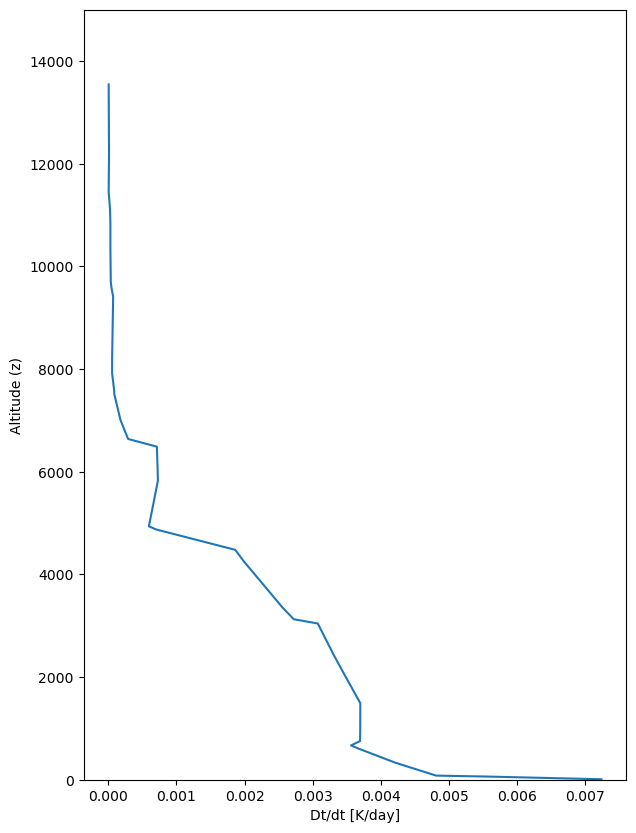

In [142]:
fig, ax = plt.subplots(figsize = (7, 10))

ax.plot(df['DT/dt - Clear'], df['z'])
ax.set_ylim(0, 15000)
ax.set_xlabel('Dt/dt [K/day]')
ax.set_ylabel('Altitude (z)')

plt.show()